In [1]:
# Importing all the necessary libraries
from tensorflow.keras.datasets import mnist
import torchvision
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
import numpy as np
import torch
from torch import nn
from collections import defaultdict
from functools import partial
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
# What is being done here:
# We are collecting all the images by classes
# Each entry in the 'output' list is 
# a numpy array of all the images by class
output = []
for i in range(10):
    classno = X_train[np.where(y_train==i)]
    output.append(classno)

In [5]:
# What is happening here:
# We are stacking the classes into one output 'total_list'
# In addition, we are also appending the cluster center into each class
# This is needed for the next step: T-Stochastic Nearest Neighbors plotting

total_list = []
indices = []
for number in range(10):
    kmeans = KMedoids(n_clusters = 1)
    kmeans.fit(output[number])
    output[number] = np.concatenate((output[number], kmeans.cluster_centers_), axis=0)
    total_list.append(output[number][:])
    if not indices:
        indices.append(output[number].shape[0])
    else:         
        indices.append(indices[-1] + output[number].shape[0])
        
total_list = np.concatenate(total_list, axis=0)

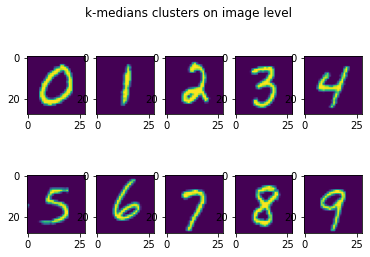

In [6]:
# Printing all the k-means cluster (0-9)
fig, axs = plt.subplots(2,5)
fig.suptitle('k-medians clusters on image level')
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(total_list[indices[5*i + j]-1].reshape(28,28))

In [7]:
# We do the TSNE transform on total_list
from sklearn.manifold import TSNE
tsne_points = TSNE(n_components=2, perplexity = 50, n_iter = 1000).fit_transform(total_list)

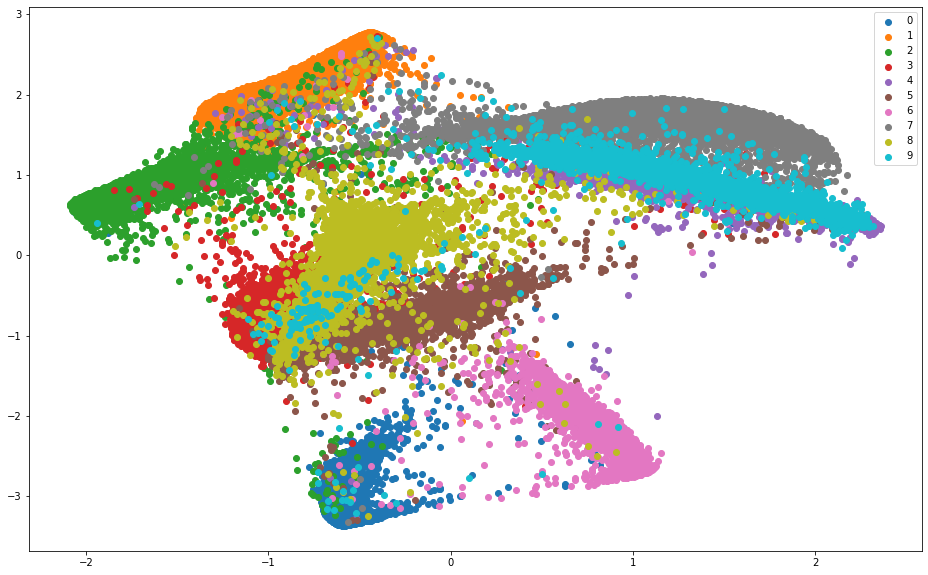

In [8]:
# Doing a naive plotting here.
# What needs to be done:
# 1. Change the color for each cluster - Done
# 2. Differentiate the color of the cluster from its centroid - Undone
# 3. Have a legend print out all the cluster with its label - Done
start = 0
plt.figure(figsize=(16,10))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuBuGn']

for i,end in enumerate(indices):
    plt.scatter(tsne_points[start:end,0], tsne_points[start:end,1], cmap=cmaps[i], label=i)
    plt.legend()
    start = end
    
# plt.savefig('mnist-k-medians-clustermaps.png')